# Response generator exploration


In [1]:
import os
import sys
import logging
from typing import List, Dict, Any
from datetime import datetime
from pydantic import BaseModel
from IPython.display import Image, display

# Add the project root to the Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

# Import necessary components
from config import Config
from core.models.message import Message, RequestMessage
from core.session_manager import SessionManager
from generators.semantic_router import SemanticRouter
from generators.llm_router import LLMRouter
from generators.hybrid_router import HybridRouter
from generators.dynamic_agent import DynamicAgent
from generators.clear_intent_agent import ClearIntentAgent
from generators.vague_intent_agent import VagueIntentAgent
from services.weaviate_service import WeaviateService
from services.openai_service import OpenAIService
from services.tavily_service import TavilyService
from services.query_processor import QueryProcessor
from prompts.prompt_manager import PromptManager
from feature_extraction.product_data_preprocessor import ProductDataProcessor

# Load configuration
config = Config()

# Configure logging
logging.basicConfig(level=logging.INFO, force=True)


In [2]:
# Initialize services
async def initialize_services():
    openai_service = OpenAIService(config.OPENAI_API_KEY, config)
    await openai_service.initialize()

    tavily_service = TavilyService(config.TAVILY_API_KEY)
    await tavily_service.connect()

    product_data_preprocessor = ProductDataProcessor()
    weaviate_service = WeaviateService(config.OPENAI_API_KEY, config.WEAVIATE_URL, product_data_preprocessor)
    await weaviate_service.initialize_weaviate(reset=config.RESET_WEAVIATE)

    query_processor = QueryProcessor(openai_service, PromptManager())

    return openai_service, tavily_service, weaviate_service, query_processor


# Initialize architectures
async def initialize_architectures(openai_service, tavily_service, weaviate_service, query_processor):
    session_manager = SessionManager()
    prompt_manager = PromptManager()

    # Initialize test session
    session_manager.initialize_session("test")

    clear_intent_agent = ClearIntentAgent(weaviate_service, query_processor, openai_service, prompt_manager)
    vague_intent_agent = VagueIntentAgent(weaviate_service, query_processor, openai_service, prompt_manager)

    semantic_router = SemanticRouter(
        session_manager, openai_service, weaviate_service, clear_intent_agent, vague_intent_agent, prompt_manager
    )
    llm_router = LLMRouter(
        session_manager, openai_service, weaviate_service, clear_intent_agent, vague_intent_agent, prompt_manager
    )
    hybrid_router = HybridRouter(
        session_manager, openai_service, weaviate_service, clear_intent_agent, vague_intent_agent, prompt_manager
    )
    dynamic_agent = DynamicAgent(session_manager, weaviate_service, openai_service, prompt_manager)

    display(Image(semantic_router.clear_intent_agent.workflow.get_graph().draw_mermaid_png()))
    display(Image(semantic_router.vague_intent_agent.workflow.get_graph().draw_mermaid_png()))
    display(Image(dynamic_agent.workflow.get_graph().draw_mermaid_png()))

    return semantic_router, llm_router, hybrid_router, dynamic_agent

In [3]:
# Helper function to run tests
async def run_test(architecture, message: str, chat_history: List[Dict[str, str]] = None):
    if chat_history is None:
        chat_history = []

    print(f"Running test for {architecture.__class__.__name__}")
    print(f"Input: {message}")

    mock_message = RequestMessage(
        id="test",
        message=message,
        timestamp=datetime.now(),
        session_id="test",
        model="gpt-4o",
        architecture_choice=architecture.__class__.__name__.lower().replace("router", "-router"),
        history_management_choice="keep-all",
    )

    response = await architecture.run(mock_message)

    print(f"Output: {response}")
    print("\n" + "-" * 50 + "\n")
    return response

In [4]:
# Initialize services and architectures
async def setup():
    services = await initialize_services()
    architectures = await initialize_architectures(*services)
    return architectures


In [5]:
# Run tests for all architectures
async def run_all_tests(architectures, test_messages):
    for arch in architectures:
        print(f"\nTesting {arch.__class__.__name__}")
        for msg in test_messages:
            await run_test(arch, msg)


# Main execution
async def main():
    architectures = await setup()
    test_messages = [
        "Hi",
        # "Find me a single-board computer with 4GB RAM and an ARM processor.",
        # "Tell me about the latest embedded systems.",
        # "What are the differences between Arduino and Raspberry Pi?",
    ]
    await run_all_tests(architectures, test_messages)


INFO:services.weaviate_service:Initializing Weaviate...
INFO:httpx:HTTP Request: GET http://localhost:8080/v1/.well-known/openid-configuration "HTTP/1.1 404 Not Found"
INFO:httpx:HTTP Request: GET http://localhost:8080/v1/meta "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://pypi.org/pypi/weaviate-client/json "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET http://localhost:8080/v1/schema "HTTP/1.1 200 OK"
INFO:weaviate_interface.schema_manager:Mismatch in property product_id
INFO:weaviate_interface.schema_manager:Property mismatch for RawProductData
INFO:httpx:HTTP Request: GET http://localhost:8080/v1/schema "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:weaviate_interface.weaviate_client:Aggregation results: AggregateReturn(properties={}, total_count=0)
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:weaviate_interface.weaviate_client:Aggregation results: AggregateReturn(properties={},

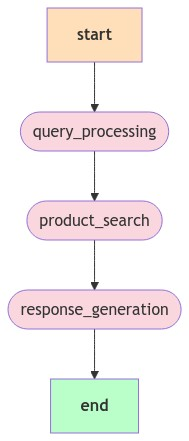

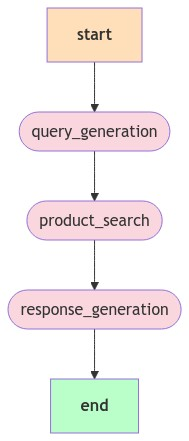

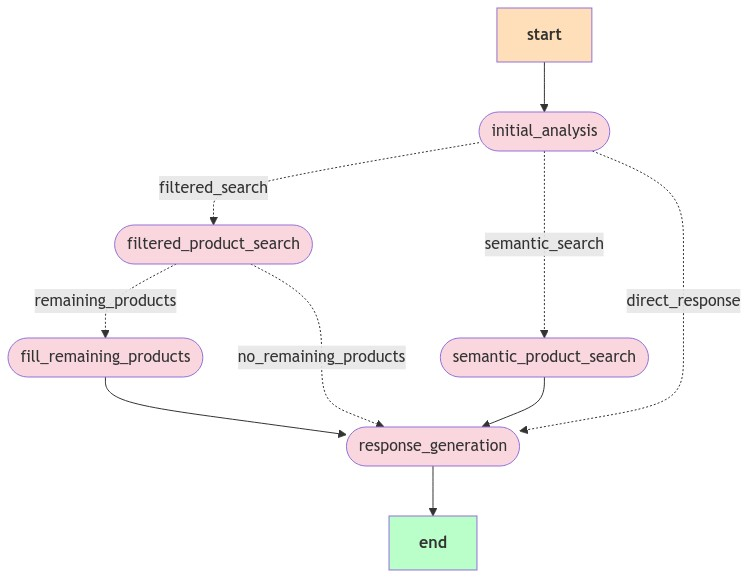

In [6]:
architectures = await setup()

In [8]:
await run_test(
    architectures[3],
    "Tell me about boards",
)

INFO:generators.dynamic_agent:Starting new DynamicAgent run for session test
DEBUG:generators.dynamic_agent:Full message details: id='test' message='Tell me about boards' timestamp=datetime.datetime(2024, 11, 4, 1, 51, 40, 986088) session_id='test' model='gpt-4o' architecture_choice='dynamicagent' history_management_choice='keep-all' is_user_message=True
INFO:generators.dynamic_agent:Beginning workflow execution
INFO:generators.dynamic_agent:Starting initial analysis for message: Tell me about boards...
DEBUG:generators.dynamic_agent:Generating analysis prompts
DEBUG:generators.dynamic_agent:Sending request to OpenAI (model: gpt-4o)
INFO:services.openai_service:


Messages: [{'role': 'system', 'content': '\nYou are an AI processing component specialized in computer hardware, particularly:\n- Embedded systems\n- Development kits\n- Industrial communication devices\n- Single-board computers\n- Microcontrollers and microprocessors\n\nYour knowledge base includes:\n- Technical specificatio

Running test for DynamicAgent
Input: Tell me about boards


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
DEBUG:generators.dynamic_agent:Raw OpenAI response: ```json
{
    "query_context": {
        "num_products_requested": 5,
        "sort_preference": null
    }
}
```
INFO:generators.dynamic_agent:Parsed analysis result: {
  "query_context": {
    "num_products_requested": 5,
    "sort_preference": null
  }
}
INFO:generators.dynamic_agent:Routing based on analysis results
DEBUG:generators.dynamic_agent:Routing to semantic search
INFO:generators.dynamic_agent:Starting semantic product search
INFO:generators.dynamic_agent:Found 5 products through semantic search
INFO:generators.dynamic_agent:Starting response generation
ERROR:generators.dynamic_agent:Error in DynamicAgent execution
Traceback (most recent call last):
  File "/Users/e729/Workspace/Tenacious/ThroughPut/backend/generators/dynamic_agent.py", line 380, in run
    final_state = await self.workflow.ainvoke(initial_state)
  File "/Users/e729

Output: {'type': 'error', 'message': 'An error occurred while processing your request.', 'products': [], 'reasoning': "'NoneType' object has no attribute 'keys'", 'follow_up_question': 'Would you like to try your query again?', 'metadata': {}}

--------------------------------------------------



{'type': 'error',
 'message': 'An error occurred while processing your request.',
 'products': [],
 'reasoning': "'NoneType' object has no attribute 'keys'",
 'follow_up_question': 'Would you like to try your query again?',
 'metadata': {}}

In [8]:
await run_test(
    architectures[3],
    "Find all SBCs that support PCIe Gen3 interface.",
)

INFO:generators.dynamic_agent:Starting new DynamicAgent run for session test
DEBUG:generators.dynamic_agent:Full message details: id='test' message='Find all SBCs that support PCIe Gen3 interface.' timestamp=datetime.datetime(2024, 11, 1, 2, 49, 0, 198651) session_id='test' model='gpt-4o' architecture_choice='dynamicagent' history_management_choice='keep-all' is_user_message=True
INFO:generators.dynamic_agent:Beginning workflow execution
INFO:generators.dynamic_agent:Starting initial analysis for message: Find all SBCs that support PCIe Gen3 interface....
DEBUG:generators.dynamic_agent:Generating analysis prompts
DEBUG:generators.dynamic_agent:Sending request to OpenAI (model: gpt-4o)
INFO:services.openai_service:


Messages: [{'role': 'system', 'content': '\nYou are an AI processing component specialized in computer hardware, particularly:\n- Embedded systems\n- Development kits\n- Industrial communication devices\n- Single-board computers\n- Microcontrollers and microprocessors\n\nYo

Running test for DynamicAgent
Input: Find all SBCs that support PCIe Gen3 interface.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
DEBUG:generators.dynamic_agent:Raw OpenAI response: ```json
{
    "filters": {
        "form_factor": "SBC",
        "io_count": "PCIE 3.0"
    },
    "query_context": {
        "num_products_requested": 5,
        "sort_preference": null
    }
}
```
INFO:generators.dynamic_agent:Parsed analysis result: {
  "filters": {
    "form_factor": "SBC",
    "io_count": "PCIE 3.0"
  },
  "query_context": {
    "num_products_requested": 5,
    "sort_preference": null
  }
}
INFO:generators.dynamic_agent:Routing based on analysis results
DEBUG:generators.dynamic_agent:Routing to filtered search with filters: {'form_factor': 'SBC', 'io_count': 'PCIE 3.0'}
INFO:generators.dynamic_agent:Starting filtered product search
DEBUG:generators.dynamic_agent:Search parameters - Limit: 5, Filters: {
  "form_factor": "SBC",
  "io_count": "PCIE 3.0"
}
INFO:generators.dynamic_agent:Found 5 products with filters
INFO:generat

Output: {'type': 'dynamic_agent', 'response': 'Found 3 SBCs that support PCIe Gen3 interface, each with unique features suitable for different applications.', 'products': [{'certifications': ['OTHER', 'EN 50155'], 'duplicate_ids': ['IB909AF-5350', 'IB909AF-5650'], 'processor_tdp': '15.0W', 'memory': 'UNKNOWN 2 X DDR4 SODIMM, MAX 32GB, NON-ECC', 'processor_core_count': '4', 'onboard_storage': 'MSATA', 'operating_temperature_max': '60°C', 'operating_temperature_min': '0°C', 'full_product_description': "The IBASE IBAF is designed for industrial applications, featuring Intel's 8th Gen Core U-Series processors with integrated graphics. It supports up to 32GB of DDR4 memory and offers a variety of I/O interfaces including USB, COM, and SATA. The board is equipped with dual PCIe GbE LAN for robust networking capabilities and supports mSATA for onboard storage.", 'io_count': ['USB 3.0', 'SATA 3.0', 'SERIAL', 'USB 2.0', 'PCIE'], 'lead_time': None, 'price': None, 'processor_manufacturer': 'INTEL

{'type': 'dynamic_agent',
 'response': 'Found 3 SBCs that support PCIe Gen3 interface, each with unique features suitable for different applications.',
 'products': [{'certifications': ['OTHER', 'EN 50155'],
   'duplicate_ids': ['IB909AF-5350', 'IB909AF-5650'],
   'processor_tdp': '15.0W',
   'memory': 'UNKNOWN 2 X DDR4 SODIMM, MAX 32GB, NON-ECC',
   'processor_core_count': '4',
   'onboard_storage': 'MSATA',
   'operating_temperature_max': '60°C',
   'operating_temperature_min': '0°C',
   'full_product_description': "The IBASE IBAF is designed for industrial applications, featuring Intel's 8th Gen Core U-Series processors with integrated graphics. It supports up to 32GB of DDR4 memory and offers a variety of I/O interfaces including USB, COM, and SATA. The board is equipped with dual PCIe GbE LAN for robust networking capabilities and supports mSATA for onboard storage.",
   'io_count': ['USB 3.0', 'SATA 3.0', 'SERIAL', 'USB 2.0', 'PCIE'],
   'lead_time': None,
   'price': None,
   'p

In [9]:
await run_test(
    architectures[3],
    "give me top 10 evaluation boards with ARM processor architecture",
)

INFO:generators.dynamic_agent:Starting new DynamicAgent run for session test
DEBUG:generators.dynamic_agent:Full message details: id='test' message='give me top 10 evaluation boards with ARM processor architecture' timestamp=datetime.datetime(2024, 11, 1, 2, 49, 12, 247569) session_id='test' model='gpt-4o' architecture_choice='dynamicagent' history_management_choice='keep-all' is_user_message=True
INFO:generators.dynamic_agent:Beginning workflow execution
INFO:generators.dynamic_agent:Starting initial analysis for message: give me top 10 evaluation boards with ARM processor architecture...
DEBUG:generators.dynamic_agent:Generating analysis prompts
DEBUG:generators.dynamic_agent:Sending request to OpenAI (model: gpt-4o)
INFO:services.openai_service:


Messages: [{'role': 'system', 'content': '\nYou are an AI processing component specialized in computer hardware, particularly:\n- Embedded systems\n- Development kits\n- Industrial communication devices\n- Single-board computers\n- Microco

Running test for DynamicAgent
Input: give me top 10 evaluation boards with ARM processor architecture


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
DEBUG:generators.dynamic_agent:Raw OpenAI response: ```json
{
    "filters": {
        "form_factor": "DEVELOPMENT BOARD",
        "processor_architecture": "ARM"
    },
    "query_context": {
        "num_products_requested": 10,
        "sort_preference": null
    }
}
```
INFO:generators.dynamic_agent:Parsed analysis result: {
  "filters": {
    "form_factor": "DEVELOPMENT BOARD",
    "processor_architecture": "ARM"
  },
  "query_context": {
    "num_products_requested": 10,
    "sort_preference": null
  }
}
INFO:generators.dynamic_agent:Routing based on analysis results
DEBUG:generators.dynamic_agent:Routing to filtered search with filters: {'form_factor': 'DEVELOPMENT BOARD', 'processor_architecture': 'ARM'}
INFO:generators.dynamic_agent:Starting filtered product search
DEBUG:generators.dynamic_agent:Search parameters - Limit: 10, Filters: {
  "form_factor": "DEVELOPMENT BOARD",
  "processor_

Output: {'type': 'dynamic_agent', 'response': 'Here are some top ARM-based evaluation boards that match your criteria, focusing on development boards with ARM architecture.', 'products': [{'certifications': [], 'evaluation_or_commercialization': 'Evaluation', 'processor_tdp': None, 'duplicate_ids': ['110110064'], 'processor_core_count': '6', 'onboard_storage': '32 GB EMMC', 'price': None, 'operating_temperature_min': None, 'full_product_description': 'The Toybrick RKPro AI Development Kit is designed for high-performance AI applications. It includes a Rockchip RK3399Pro SoC with a dual-core Cortex-A72 and quad-core Cortex-A53 CPU, Mali-T860 MP4 GPU, and a 3 TOPs NPU. The board supports dual OS boot with Android and Linux, and offers extensive connectivity options including PCIe, USB Type-C, HDMI, and more. It is ideal for AI development with support for TensorFlow and Caffe models.', 'io_count': ['USB'], 'lead_time': None, 'operating_temperature_max': None, 'processor_manufacturer': 'R

{'type': 'dynamic_agent',
 'response': 'Here are some top ARM-based evaluation boards that match your criteria, focusing on development boards with ARM architecture.',
 'products': [{'certifications': [],
   'evaluation_or_commercialization': 'Evaluation',
   'processor_tdp': None,
   'duplicate_ids': ['110110064'],
   'processor_core_count': '6',
   'onboard_storage': '32 GB EMMC',
   'price': None,
   'operating_temperature_min': None,
   'full_product_description': 'The Toybrick RKPro AI Development Kit is designed for high-performance AI applications. It includes a Rockchip RK3399Pro SoC with a dual-core Cortex-A72 and quad-core Cortex-A53 CPU, Mali-T860 MP4 GPU, and a 3 TOPs NPU. The board supports dual OS boot with Android and Linux, and offers extensive connectivity options including PCIe, USB Type-C, HDMI, and more. It is ideal for AI development with support for TensorFlow and Caffe models.',
   'io_count': ['USB'],
   'lead_time': None,
   'operating_temperature_max': None,
 

This notebook demonstrates and tests the four architecture implementations from the generators folder:
1. Semantic Router
2. LLM Router
3. Hybrid Router
4. Dynamic Agent

We'll import the necessary components, set up the required services, and run test prompts for each architecture.


## LLM ROUTER

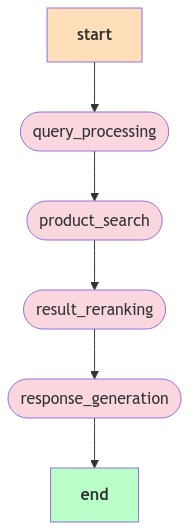

In [6]:
arch = architectures[1]
display(Image(arch.clear_intent_agent.workflow.get_graph().draw_mermaid_png()))

In [9]:
await run_test(arch, "Find all SBCs that support PCIe Gen3 interface.")

INFO:generators.dynamic_agent:Running DynamicAgent with message: id='test' message='Find all SBCs that support PCIe Gen3 interface.' timestamp=datetime.datetime(2024, 10, 7, 17, 9, 40, 178460) session_id='test' model='gpt-4o' architecture_choice='dynamicagent' history_management_choice='keep-all' is_user_message=True
INFO:prompts.prompt_manager:===:> Generating dynamic agent prompt for query: Find all SBCs that support PCIe Gen3 interface.


Running test for DynamicAgent
Input: Find all SBCs that support PCIe Gen3 interface.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:services.query_processor:

Rerank_products response from OpenAI: {'products': [{'name': 'PCIEQ', 'relevance_score': 0.9, 'matching_criteria': ['PCIe Gen3', 'Single-board computer'], 'missing_criteria': ["Form factor does not match 'Single-board computer' exactly, as it is 'PICMG'"]}, {'name': 'SPCIEC', 'relevance_score': 0.85, 'matching_criteria': ['PCIe Gen3'], 'missing_criteria': ["Form factor does not match 'Single-board computer' exactly, as it is 'PICMG'"]}, {'name': 'PCEGA', 'relevance_score': 0.8, 'matching_criteria': ['PCIe Gen3'], 'missing_criteria': ["Form factor does not match 'Single-board computer' exactly, as it is 'Slot SBC'"]}, {'name': 'PCIEH', 'relevance_score': 0.75, 'matching_criteria': ['PCIe

Output: {'type': 'dynamic_agent', 'response': 'I found several products that support the PCIe Gen3 interface, but none of them are strictly single-board computers (SBCs) in the traditional sense. They are mostly variations of SBCs or other form factors like PICMG, Slot SBC, and COM Express modules.', 'products': [{'name': 'PCIEQ', 'relevance_score': 0.9, 'matching_criteria': ['PCIe Gen3', 'Single-board computer'], 'missing_criteria': ["Form factor does not match 'Single-board computer' exactly, as it is 'PICMG'"]}, {'name': 'SPCIEC', 'relevance_score': 0.85, 'matching_criteria': ['PCIe Gen3'], 'missing_criteria': ["Form factor does not match 'Single-board computer' exactly, as it is 'PICMG'"]}, {'name': 'PCEGA', 'relevance_score': 0.8, 'matching_criteria': ['PCIe Gen3'], 'missing_criteria': ["Form factor does not match 'Single-board computer' exactly, as it is 'Slot SBC'"]}, {'name': 'PCIEH', 'relevance_score': 0.75, 'matching_criteria': ['PCIe Gen3'], 'missing_criteria': ["Form factor

{'type': 'dynamic_agent',
 'response': 'I found several products that support the PCIe Gen3 interface, but none of them are strictly single-board computers (SBCs) in the traditional sense. They are mostly variations of SBCs or other form factors like PICMG, Slot SBC, and COM Express modules.',
 'products': [{'name': 'PCIEQ',
   'relevance_score': 0.9,
   'matching_criteria': ['PCIe Gen3', 'Single-board computer'],
   'missing_criteria': ["Form factor does not match 'Single-board computer' exactly, as it is 'PICMG'"]},
  {'name': 'SPCIEC',
   'relevance_score': 0.85,
   'matching_criteria': ['PCIe Gen3'],
   'missing_criteria': ["Form factor does not match 'Single-board computer' exactly, as it is 'PICMG'"]},
  {'name': 'PCEGA',
   'relevance_score': 0.8,
   'matching_criteria': ['PCIe Gen3'],
   'missing_criteria': ["Form factor does not match 'Single-board computer' exactly, as it is 'Slot SBC'"]},
  {'name': 'PCIEH',
   'relevance_score': 0.75,
   'matching_criteria': ['PCIe Gen3'],


In [8]:
await run_test(arch, "What is single board computer")

Running test for LLMRouter
Input: What is single board computer


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:generators.llm_router:Route determined: {'category': 'vague_intent_product', 'justification': 'The query asks for information about a single board computer but does not specify any technical criteria or constraints.', 'confidence': 90}
INFO:generators.vague_intent_agent:Running VagueIntentAgent with message: id='test' message='What is single board computer' timestamp=datetime.datetime(2024, 10, 7, 12, 43, 13, 254367) session_id='test' model='gpt-4o' architecture_choice='llm-router' history_management_choice='keep-all' is_user_message=True
INFO:generators.vague_intent_agent:Starting workflow execution
INFO:prompts.prompt_manager:Generating semantic search query prompt for query: What is single board computer
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:

Output: {'type': 'vague_intent_product', 'response': 'A single board computer (SBC) is a complete computer built on a single circuit board, with microprocessor(s), memory, input/output (I/O), and other features required for a functional computer. SBCs are used in a wide range of applications, from industrial automation to IoT devices, due to their compact size, versatility, and cost-effectiveness. They often support various operating systems and can be tailored for specific tasks or environments.', 'products': [{'certifications': ['CE', 'FCC Class B'], 'duplicate_ids': ['RSB-4710CO-ANA1E', 'RSB-4710CO-XLA1E', 'RSB-4710CO-XNA1E', 'RSB-4710WO-XLA1E', 'RSB-4710WO-XNA1E'], 'processor_tdp': None, 'evaluation_or_commercialization': 'Commercial', 'onboard_storage': '16 GB eMMC', 'processor_core_count': '6', 'price': None, 'operating_temperature_min': '-20°C', 'full_product_description': 'The RSB is an industrial-grade single board computer designed for high-performance applications. It featur

{'type': 'vague_intent_product',
 'response': 'A single board computer (SBC) is a complete computer built on a single circuit board, with microprocessor(s), memory, input/output (I/O), and other features required for a functional computer. SBCs are used in a wide range of applications, from industrial automation to IoT devices, due to their compact size, versatility, and cost-effectiveness. They often support various operating systems and can be tailored for specific tasks or environments.',
 'products': [{'certifications': ['CE', 'FCC Class B'],
   'duplicate_ids': ['RSB-4710CO-ANA1E',
    'RSB-4710CO-XLA1E',
    'RSB-4710CO-XNA1E',
    'RSB-4710WO-XLA1E',
    'RSB-4710WO-XNA1E'],
   'processor_tdp': None,
   'evaluation_or_commercialization': 'Commercial',
   'onboard_storage': '16 GB eMMC',
   'processor_core_count': '6',
   'price': None,
   'operating_temperature_min': '-20°C',
   'full_product_description': 'The RSB is an industrial-grade single board computer designed for high-p

## Semantic Router


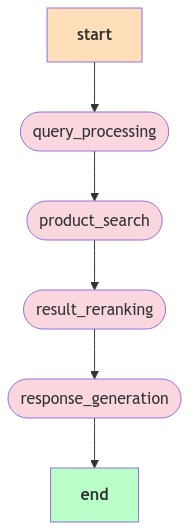

In [11]:
arch = architectures[0]
display(Image(arch.clear_intent_agent.workflow.get_graph().draw_mermaid_png()))


## Hybrid Router


In [ ]:
arch = architectures[2]
display(Image(arch.clear_intent_agent.workflow.get_graph().draw_mermaid_png()))


## Dynamic Agent


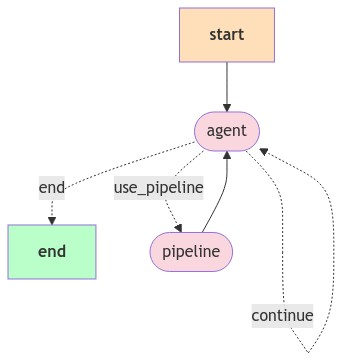

In [7]:
arch = architectures[3]
display(Image(arch.workflow.get_graph().draw_mermaid_png()))


In [8]:
await run_test(arch, "What is single board computer")

INFO:generators.dynamic_agent:Running DynamicAgent with message: id='test' message='What is single board computer' timestamp=datetime.datetime(2024, 10, 7, 14, 41, 52, 15425) session_id='test' model='gpt-4o' architecture_choice='dynamicagent' history_management_choice='keep-all' is_user_message=True
INFO:prompts.prompt_manager:===:> Generating dynamic agent prompt for query: What is single board computer


Running test for DynamicAgent
Input: What is single board computer


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Output: {'type': 'dynamic_agent', 'response': '```json\n{\n    "message": "A single-board computer (SBC) is a complete computer built on a single circuit board, with microprocessor(s), memory, input/output (I/O), and other features required for a functional computer. Unlike traditional desktop computers, SBCs are compact and often used in embedded systems, industrial automation, and educational projects. Popular examples include the Raspberry Pi, BeagleBone, and Arduino boards.",\n    "products": [],\n    "reasoning": "The user asked for a definition of a single-board computer, which is a well-known concept in the field of computer hardware. Therefore, a tool search was not necessary. I provided a concise explanation of what an SBC is, along with examples to illustrate the concept.",\n    "follow_up_question": "Are you looking for a specific single-board computer for a particular project or application?"\n}\n```', 'products': [], 'reasoning': '', 'follow_up_question': '', 'metadata': {

{'type': 'dynamic_agent',
 'response': '```json\n{\n    "message": "A single-board computer (SBC) is a complete computer built on a single circuit board, with microprocessor(s), memory, input/output (I/O), and other features required for a functional computer. Unlike traditional desktop computers, SBCs are compact and often used in embedded systems, industrial automation, and educational projects. Popular examples include the Raspberry Pi, BeagleBone, and Arduino boards.",\n    "products": [],\n    "reasoning": "The user asked for a definition of a single-board computer, which is a well-known concept in the field of computer hardware. Therefore, a tool search was not necessary. I provided a concise explanation of what an SBC is, along with examples to illustrate the concept.",\n    "follow_up_question": "Are you looking for a specific single-board computer for a particular project or application?"\n}\n```',
 'products': [],
 'reasoning': '',
 'follow_up_question': '',
 'metadata': {'in

In [8]:
await run_test(arch, "List Single Board Computers with a processor frequency of at least 1.8 GHz and support for Linux.")

INFO:generators.dynamic_agent:Running DynamicAgent with message: id='test' message='List Single Board Computers with a processor frequency of at least 1.8 GHz and support for Linux.' timestamp=datetime.datetime(2024, 10, 7, 14, 56, 39, 936946) session_id='test' model='gpt-4o' architecture_choice='dynamicagent' history_management_choice='keep-all' is_user_message=True
INFO:prompts.prompt_manager:===:> Generating dynamic agent prompt for query: List Single Board Computers with a processor frequency of at least 1.8 GHz and support for Linux.


Running test for DynamicAgent
Input: List Single Board Computers with a processor frequency of at least 1.8 GHz and support for Linux.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:services.query_processor:

Rerank_products response from OpenAI: {'products': [{'name': 'INTEL ATOM E SERIES SINGLE BOARD COMPUTER', 'relevance_score': 0.95, 'matching_criteria': ['Form Factor: Single Board Computer', 'Processor Speed: 1.8 GHz', 'Operating System BSP: Linux'], 'missing_criteria': []}, {'name': 'WAFER-AL', 'relevance_score': 0.9, 'matching_criteria': ['Form Factor: Single Board Computer', 'Operating System BSP: Linux'], 'missing_criteria': ['Processor Speed: 1.8 GHz']}, {'name': 'SBCEKL', 'relevance_score': 0.85, 'matching_criteria': ['Form Factor: Single Board Computer', 'Operating System BSP: Linux'], 'missing_criteria': ['Processor Speed: 1.8 GHz']}, {'name': 'CPU MINIITX SBC', 'relevance_score

Output: {'type': 'dynamic_agent', 'response': 'The INTEL ATOM E SERIES SINGLE BOARD COMPUTER meets your criteria with a processor frequency of at least 1.8 GHz and support for Linux.', 'products': [{'name': 'INTEL ATOM E SERIES SINGLE BOARD COMPUTER', 'relevance_score': 0.95, 'matching_criteria': ['Form Factor: Single Board Computer', 'Processor Speed: 1.8 GHz', 'Operating System BSP: Linux'], 'missing_criteria': []}], 'reasoning': 'The search results indicate that the INTEL ATOM E SERIES SINGLE BOARD COMPUTER is the only product that matches all the specified criteria: it is a single board computer with a processor speed of at least 1.8 GHz and supports Linux. Other products either do not meet the processor speed requirement or are missing other criteria.', 'follow_up_question': 'Are there any other specific features or specifications you are looking for in a single board computer?', 'metadata': {'input_token_usage': {'agent': 2265}, 'output_token_usage': {'agent': 191}, 'time_taken':

{'type': 'dynamic_agent',
 'response': 'The INTEL ATOM E SERIES SINGLE BOARD COMPUTER meets your criteria with a processor frequency of at least 1.8 GHz and support for Linux.',
 'products': [{'name': 'INTEL ATOM E SERIES SINGLE BOARD COMPUTER',
   'relevance_score': 0.95,
   'matching_criteria': ['Form Factor: Single Board Computer',
    'Processor Speed: 1.8 GHz',
    'Operating System BSP: Linux'],
   'missing_criteria': []}],
 'reasoning': 'The search results indicate that the INTEL ATOM E SERIES SINGLE BOARD COMPUTER is the only product that matches all the specified criteria: it is a single board computer with a processor speed of at least 1.8 GHz and supports Linux. Other products either do not meet the processor speed requirement or are missing other criteria.',
 'follow_up_question': 'Are there any other specific features or specifications you are looking for in a single board computer?',
 'metadata': {'input_token_usage': {'agent': 2265},
  'output_token_usage': {'agent': 191